<a href="https://colab.research.google.com/github/vinnimichelin/Clusterizacao_Ecommerce/blob/main/Projeto_Clusteriza%C3%A7%C3%A3o_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contexto**

Você foi contratado por uma empresa de e-commerce que está buscando entender
melhor o comportamento de seus clientes para personalizar as suas campanhas de
marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo
dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:
* Clientes que compram os mesmos produtos;
* Clientes que possuem a mesma frequência de compras;
* Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a
sua base de clientes e personalizar as suas campanhas de marketing, direcionando
promoções e ofertas aos clientes com base no comportamento de compras.


# **Análise Exploratória**

In [ ]:
%%capture
%pip install sidetable

In [ ]:
#Importando as bibliotecas

import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [ ]:
#Setando os atributos padrão das plotagens

sns.set_theme(
    context='talk',
    style='dark',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

In [ ]:
#Carregando a base de dados

df = pd.read_csv('data.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Coluna - Descrição**

* InvoiceNo - Identificação da transação
* StockCode - Código de estoque do produto
* Description - Descrição do produto
* Quantity - Quantidade de produtos por transação
* InvoiceDate - Data da transação
* UnitPrice - Preço unitário do produto
* CustomerID - Identificação do cliente
* Country - País de origem da transação

In [ ]:
#Visualizando as informações da base de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
#Verificando se nossa coluna InvoiceNo possui células com letras, para assim confirmar se será necessário alterar o Dtype ou não.

#Neste caso não será necessário, pois a mesma possui células com letras, sendo assim um Dtype object e não Int.

df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

In [ ]:
#Verificando quantos dados únicos possuem nas colunas de descrição e país

df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

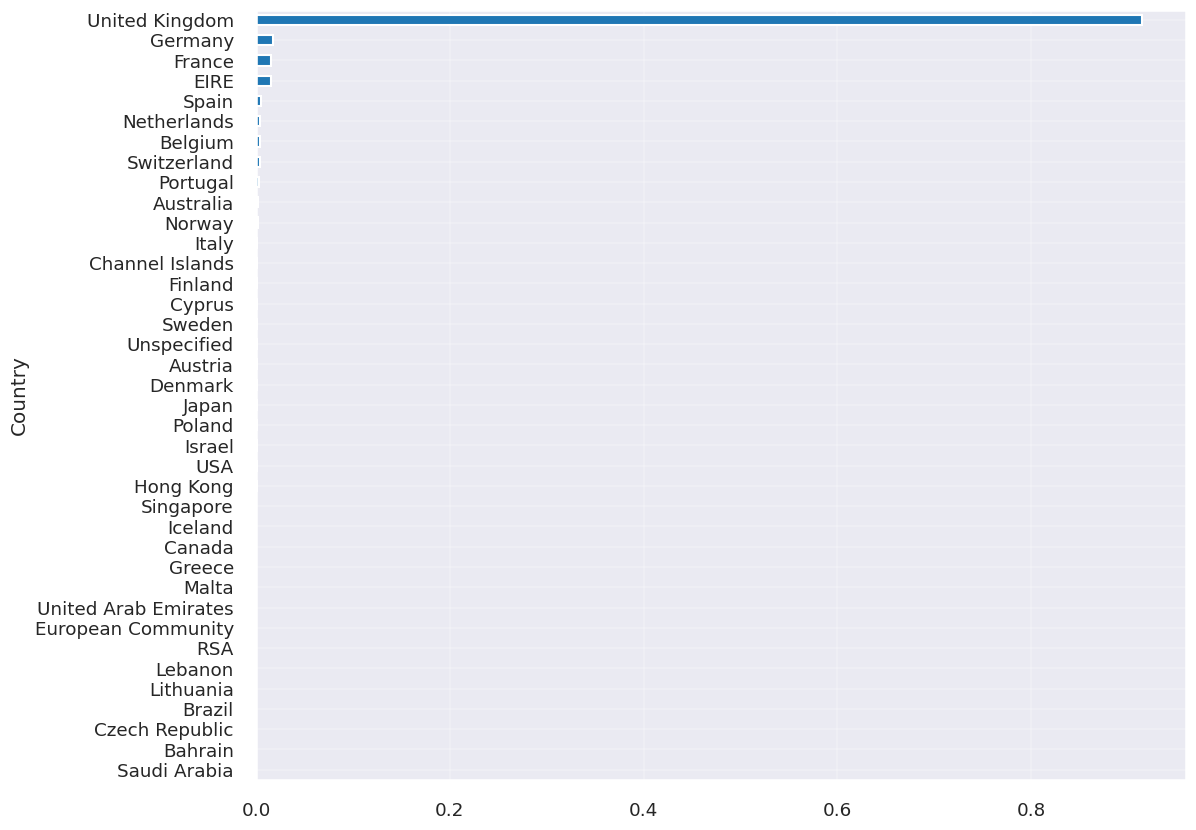

In [ ]:
#Plotando um gráfico de barras que mostra o quanto determinado país está presente na base de dados.

df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10));

In [ ]:
#Na frequência abaixo, podemos ver que o Reino Unido ocupa mais de 90% da base.

df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
#Descrevendo os nossos dados numericos

df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [ ]:
#Verificando a quantidade de dados nulos em nossa base

df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

In [ ]:
#Verificando a quantidade de dados duplicados em nossa base

df.duplicated().sum()

5268

In [ ]:
#Verificando os missing values da nossa base

df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


# **Preparação dos Dados**





**Para iniciarmos a preparação, irei dropar a coluna StockCode. Não considero a mesma relevante para o prosseguimento dos nossos estudos, pois não iremos usar a mesma em nenhuma filtragem.**

In [ ]:
#Dropando a coluna StockCode

df = df.drop(columns=['StockCode'])

In [ ]:
#Dropando os dados nulos da coluna CustomerID

df = df.dropna(subset=['CustomerID'])

In [ ]:
#Podemos ver que após droparmos os dados nulos da coluna CustomerID, não temos mais nenhum missing value em nossa base

df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [ ]:
#Alterando o Dtype da coluna InvoiceDate de object para datetime

df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [ ]:
#Alterando o Dtype da coluna CustomerID de float para int

df['CustomerID'] = df['CustomerID'].astype(int)

#Alterando o Dtype da coluna Country de object para category

df['Country'] = df['Country'].astype('category')

In [ ]:
#Podemos ver abaixo que agora todos os nossos Dtypes estão corretos e nossa base se encontra sem nenhum dado nulo

df = df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   Description  406829 non-null  object        
 2   Quantity     406829 non-null  int64         
 3   InvoiceDate  406829 non-null  datetime64[ns]
 4   UnitPrice    406829 non-null  float64       
 5   CustomerID   406829 non-null  int64         
 6   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 22.1+ MB


In [ ]:
#Verificando a primeira e a última data de nossa base

df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [ ]:
#Removendo os dados numericos abaixo de 0 de nossa base

below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

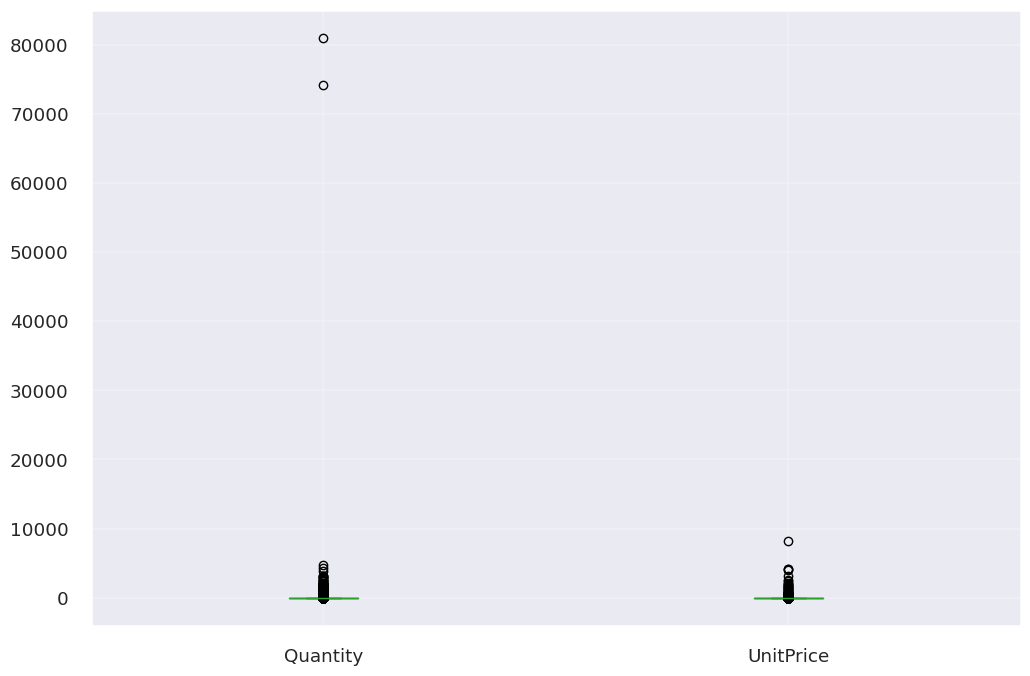

In [ ]:
#Gerando um plot para localizarmos os dados outliers

df[['Quantity','UnitPrice']].plot.box()

In [ ]:
#Esses são nossos dados outliers na coluna Quantity

df.query('Quantity>10_000')

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [ ]:
#Esse é o nosso outlier na coluna UnitPrice

df.query('UnitPrice>8_000')

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [ ]:
#Removendo os outliers da nossa base original

df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

<Axes: >

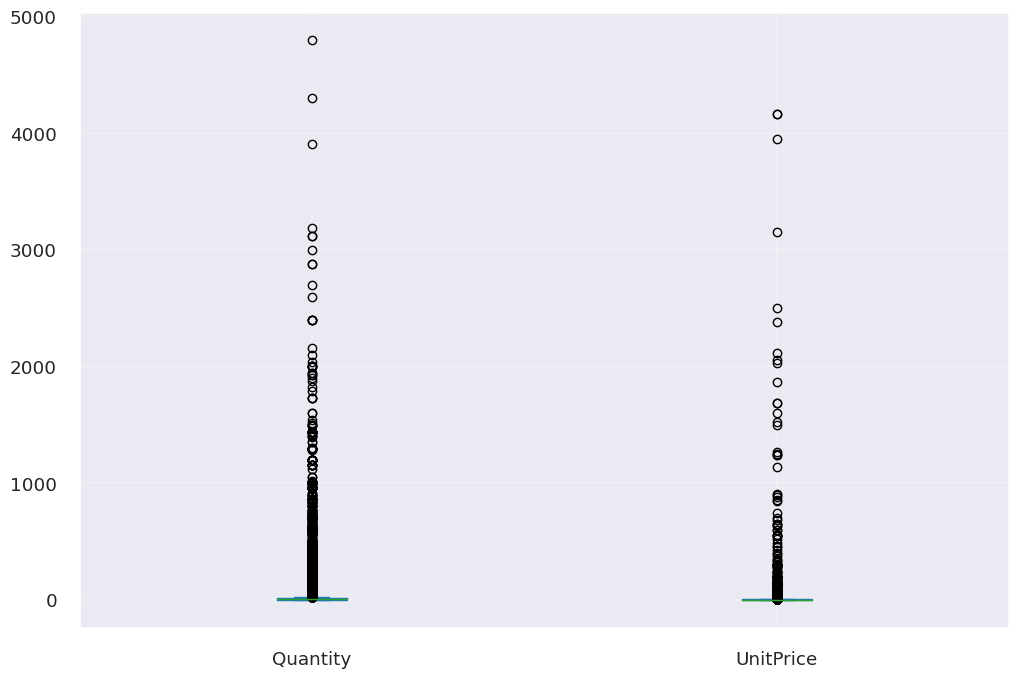

In [ ]:
#Agora temos os dados numericos mais próximos

df[['Quantity','UnitPrice']].plot.box()

In [ ]:
#Criando uma coluna extra com o preço total. Composta pela multiplicação da quantidade pelo preço unitário

df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...
541904,581587,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


**Efetuarei a normalização dos dados apenas dentro da base de RFM.**

# **RFM**

**Irei utilizar o modelo RFM apresentado no case da matéria 7, pois o mesmo está melhor diagramado e mais fácil para entendimento.**

In [ ]:
#Fazendo uma base RFM em cima da nossa base principal

df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days), #Recência
      F = ('InvoiceNo', 'nunique'), #Frequência
      M = ('price_total', 'mean') #Ticket Médio
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


In [ ]:
#Descrevendo os dados da base RFM

df_rfm.describe()

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,114.053032,4.272308,37.614122
std,99.966159,7.697064,239.369450
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.340909
50%,72.000000,2.000000,17.716923
75%,164.000000,5.000000,24.846154
max,395.000000,209.000000,13305.500000


In [ ]:
#Criando uma nova base RFM com os valores normalizados

from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()

df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563205,1.201915,0.407780
12348,0.323058,0.660638,1.325436
12349,-0.809404,-1.158248,0.426725
12350,1.568377,-1.158248,0.189783
12352,-0.308095,1.309739,0.652645
...,...,...,...
18280,1.475517,-1.158248,0.086135
18281,1.107080,-1.158248,-0.490091
18282,-1.275156,-0.195827,-0.160171


<Axes: >

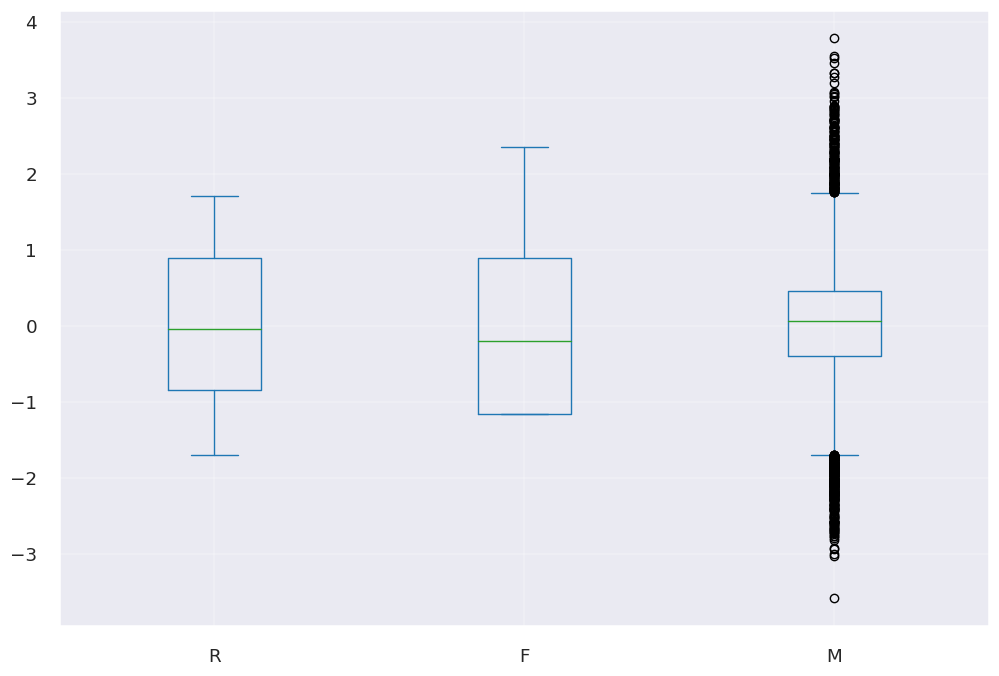

In [ ]:
#Com a nossa base RFM normalizada podemos observar que os dados se comportam de maneira mais uniforme, conforme a plotagem abaixo:

df_rfm_scaled.plot.box()

In [ ]:
#Tendo em vista que os valores máximos da base RFM estão descrepantes dos demais, iremos diminuir o quantile máximo para 90% e formar uma nova base clipada

df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.90)))
df_rfm_clip.describe()

,R,F,M
count,4337.000000,4337.000000,4337.000000
mean,108.668434,3.319115,20.784198
std,87.824805,2.653513,13.224702
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.340909
50%,72.000000,2.000000,17.716923
75%,164.000000,5.000000,24.846154
max,284.000000,9.000000,50.475818


In [ ]:
#Normalizando a base clipada

df_rfm_clip_scaled = df_rfm_clip.apply(scale)

# **Selecionando um Algoritmo de Clusterização**

## **K-Means**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

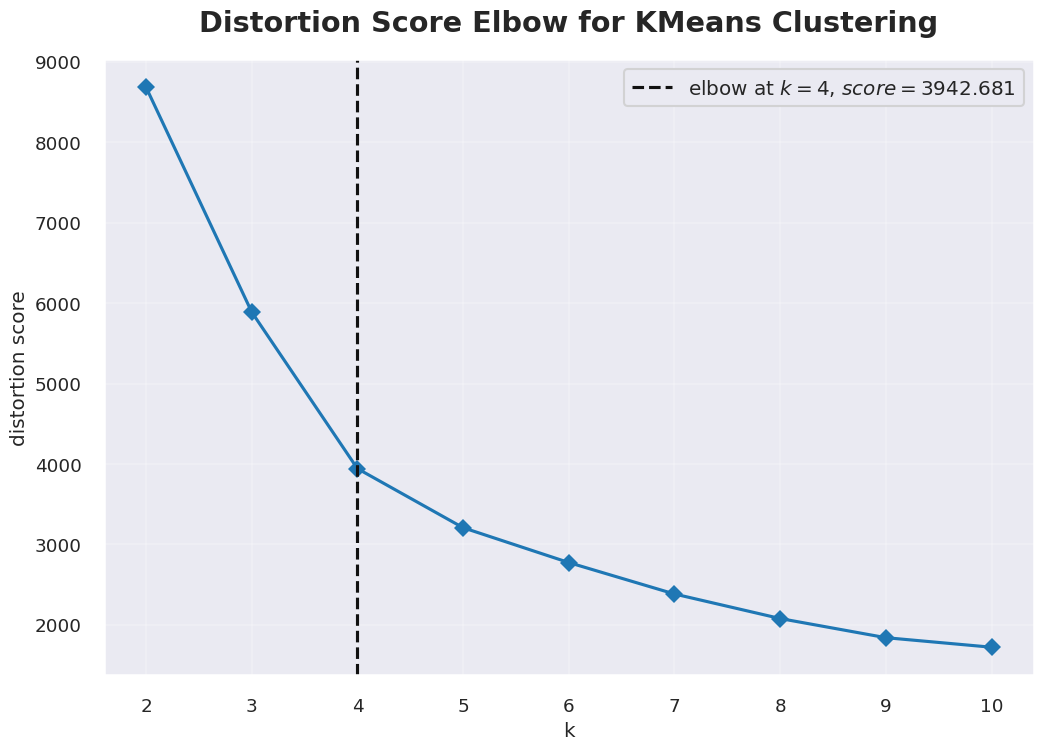

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
#Plotando o gráfico cotovelo para descobrirmos a quantidade ideal de clusters

kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
#Tirando as métricas para verificarmos quantos clusters serão necessários para o agrupamento ideal dos grupos

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8685.293469,0.355588,1.121485,2159.055113
3,5889.332590,0.384964,1.016109,2620.441797
4,3942.682372,0.435001,0.793481,3322.033263
5,3207.743044,0.435423,0.799328,3309.781095
6,2774.295797,0.434059,0.765005,3196.151668
7,2383.422307,0.376971,0.895759,3217.885772
8,2078.390405,0.373737,0.870671,3253.053210
9,1840.238400,0.363536,0.908507,3284.031578
10,1709.586866,0.358810,0.931452,3178.282734


In [ ]:
#O gráfico cotovelo e as métricas nos indicaram 4 clusters, então este será o valor que iremos utilizar

kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#Plotando o gráfico 3D

px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

## **Hierarchical Clustering**

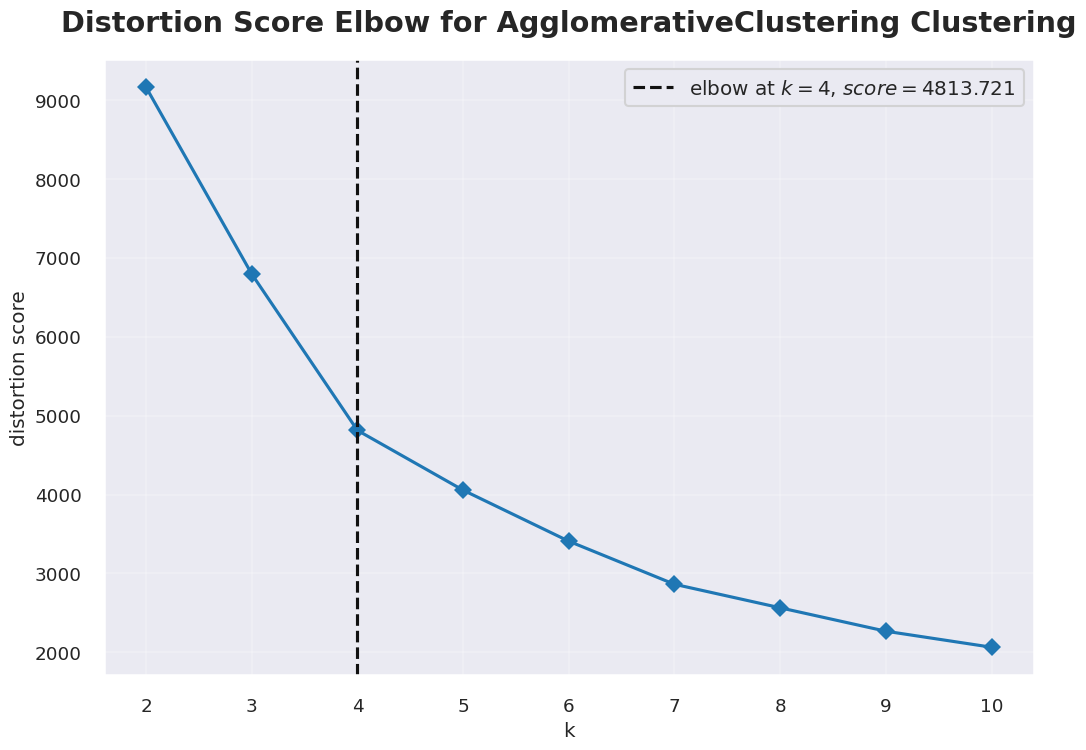

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
#Plotando o gráfico cotovelo para descobrirmos a quantidade ideal de clusters

kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [ ]:
#Tirando as métricas para verificarmos quantos clusters serão necessários para o agrupamento ideal dos grupos

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.298493,1.398450,1820.103607
3,0.302997,1.176071,1981.767246
4,0.359267,0.987377,2459.553342
5,0.364031,0.909401,2391.472887
6,0.364208,0.875811,2440.226786
7,0.319234,0.931265,2558.352248
8,0.320566,0.880566,2519.037455
9,0.303296,0.944677,2563.120570
10,0.293448,1.023619,2549.055934


In [ ]:
#O gráfico cotovelo e as métricas nos indicaram 4 clusters, então este será o valor que iremos utilizar

hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [ ]:
#Plotando o gráfico 3D

px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

## **DBSCAN**

In [ ]:
#Definindo a base RFM clipada e normalizada como o X

X = df_rfm_clip_scaled

#Setando as métricas do modelo

model = DBSCAN(eps=0.60, min_samples=100) #Após testes, selecionei estas métricas pois clusterizaram melhor os dados

#Treinando o modelo

dbscan_labels = model.fit_predict(X)

In [ ]:
#Plotando o gráfico 3D

px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=dbscan_labels.astype(str), template='plotly_dark')

## **Mean Shift**

In [ ]:
#Definindo a base RFM clipada e normalizada como o X

X = df_rfm_clip_scaled

#Setando as métricas do modelo

model = MeanShift(bandwidth=1.4) #Após testes, selecionei estas métricas pois clusterizaram melhor os dados

#Treinando o modelo

ms_labels = model.fit_predict(X)

In [ ]:
#Plotando o gráfico 3D

px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=ms_labels.astype(str), template='plotly_dark')

**Após as análises de todos os modelos, selecionei o K-Means como o modelo que mais se encaixa com o desafio do case.**

**O mesmo conseguiu agrupar com mais precisão os clientes em seus devidos grupos e apresentou uma divergência maior entre eles, o que facilita a análise.**

# **Análise dos Clusters Obtidos**

In [ ]:
#Fazendo um DataFrame com os centróides

centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

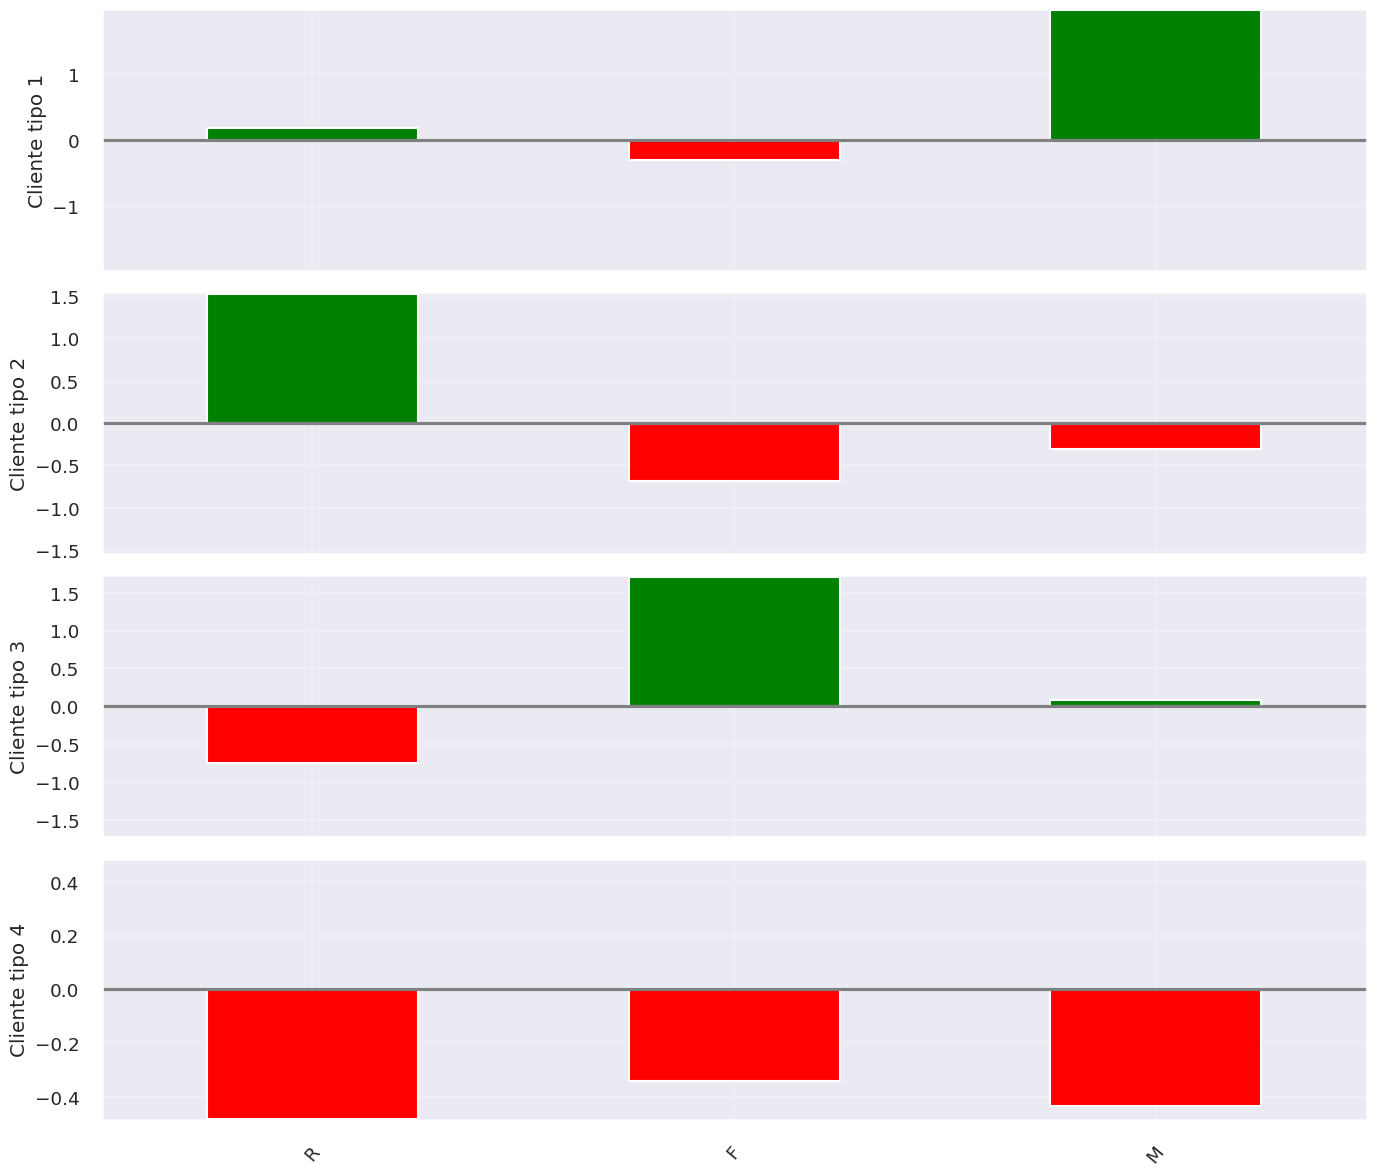

In [ ]:
#Plotando os gráficos de barra para analisar melhor os clusters

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cliente tipo {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [ ]:
#Tirando as métricas para analisar os padrões e características em comum entre os clientes

(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,124.732240,242.879630,43.126437,66.401850
F,2.517304,1.514403,7.862069,2.415725
M,46.679541,16.689003,21.810909,15.065158


# **Interpretação dos Resultados Obtidos**

## **Perfil de Compras dos Clientes**


**Cliente tipo 1:** O cliente "peixe grande". Possui uma recência grande, uma frequência um pouco abaixo, mas o seu ticket médio é altíssimo. O tipo de cliente que sempre gasta muito toda vez que vem à empresa.

**Cliente tipo 2:** O cliente "churn". Baixíssima frequência, um baixo ticket médio e uma recência altíssima. Provavelmente comprou nossos produtos, não gostou da qualidade e não voltou a comprar mais.

**Cliente tipo 3:** O cliente "da casa". Tem altíssima frequência de compras com a nossa empresa, baixa recência pois sempre está comprando e possui um bom ticket médio.

**Cliente tipo 4:** O cliente "novo". Fez compras recentemente, não tem uma frequência alta por não conhecer a empresa a muito tempo e ainda possui um ticket médio baixo pois não teve tempo de validar nossos produtos.




## **Campanhas de Marketing Personalizadas**

Acredito que com as análises feitas sobre o tipo de clientes que temos em nossa base, poderemos ter ações de marketing mais assertivas no mercado. Pois conhecendo o perfil dos clientes saberemos onde agir, e o mais importante: saberemos seus pontos fortes e fracos.


# **Possíveis Ações**

**Melhoria Futura e Recuperação de Churn:** Entrar em contato com alguns dos nossos clientes "churn" para fazermos um pós venda, descobrir qual foi o motivo para não voltar a comprar com a empresa, e assim melhorar para nossos futuros clientes e também oferecer promoções para o mesmo voltar a ser nosso cliente.

**Pequeno Peixe Grande:** Entrar em contato com alguns dos nossos clientes "peixe grande" para entendermos o que faz os mesmos gastarem tanto em nossa empresa e à partir disso, oferecermos os mesmos produtos, serviços e/ou descontos para os nossos clientes "da casa" para que possívelmente se tornem clientes "peixe grande".